In [1]:
import tensorflow as tf
from flows import DistLSTM, NormalRW, DFlow, ResFlow, NVPFlow, phase, Normal, floatX, MVNormal, MVNormalRW, Linear, CFlow, LinearChol
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from tensorflow.contrib.distributions import WishartCholesky
import flows

np.random.seed(1234)

Instructions for updating:
Use the retry module or similar alternatives.


In [2]:
# flows.floatX = 'float32'

In [3]:
# floatX = flows.floatX.

In [4]:
data = pd.read_csv('./data/test_rus_data.csv').values.astype(floatX).T[np.newaxis][:,2:]/100

In [5]:
stds = (data[0,1:] - data[0,:-1]).std(axis=0)
print(stds)
data /= stds

[0.21742282 0.16835931 0.01139835]


In [6]:
xs = data

In [7]:
n = data.shape[1]
s1 = 0.01
s_shock = 0.02
s0 = 2.
dim = [3,4]

k = dim[0] * dim[1]
# with tf.variable_scope('pwalk_inf', reuse=tf.AUTO_REUSE):
#     ldiag = DFlow([NVPFlow(dim=k, name='ldiag_flow_' + str(i)) for i in range(4)])
#     ldiag.logdens -= tf.reduce_sum(ldiag.output)
# PWalk = MVNormalRW(dim[0]*dim[1], sigma=s1, sigma0=s0, name='param_walk_prior', 
#                    ldiag=ldiag.output[0]+np.log(1/s1))
# PWalk = MVNormalRW(dim[0]*dim[1], sigma=s1, sigma0=s0, name='param_walk_prior')
PWalk = NormalRW(dim=None, sigma0=s0, sigma=s1, name='OrdWalk')
PWalk_shock = NormalRW(dim=None, sigma0=s0, sigma=s_shock, name='ShockWalk')

In [8]:
def autoregr_tf(X, param):
    d = param[:,:dim[-1]-1]
    X = tf.matmul(X, d) + param[:,-1][np.newaxis]
    return X

In [9]:
dim_ = dim[0]*dim[1]

init = Normal([1,n, dim_], sigma=0.01)
out_sample = init.sample()

flows_0 = [LinearChol(dim_, name='lc0_0', use_bias=False)(out_sample[:,0,:])]
for i in range(n-1):
    aux = flows_0[-1][-1].output
    new = LinearChol(dim_, name='lc0_{}'.format(i+1), aux_vars=aux, use_bias=False)(out_sample[:,i+1,:])
    flows_0.append(new)

In [10]:
flows = flows_0
outputs = [x[-1].output for x in flows_0]
outputs = tf.concat(outputs, axis=0)
outputs += tf.Variable(np.zeros([n,dim_], floatX))
outputs = tf.cumsum(outputs)[tf.newaxis]

In [11]:
# init_out = tf.stack([outputs[0,0]]*n)[tf.newaxis]

# outputs = tf.where(phase, outputs, init_out)

In [12]:
# init_out

In [13]:
outputs

<tf.Tensor 'strided_slice_20:0' shape=(1, 20, 12) dtype=float64>

In [14]:
prior_ord = PWalk.logdens(outputs, reduce=False)
prior_shock = PWalk_shock.logdens(outputs, reduce=False)

In [15]:
prior_ord, prior_shock

(<tf.Tensor 'OrdWalk_1/concat:0' shape=(1, 20) dtype=float64>,
 <tf.Tensor 'ShockWalk_1/concat:0' shape=(1, 20) dtype=float64>)

In [16]:
aux = tf.range(0,19, dtype=floatX)[tf.newaxis,:,tf.newaxis]
aux

<tf.Tensor 'strided_slice_21:0' shape=(1, 19, 1) dtype=float64>

In [17]:
shock_d = DistLSTM(2, name='Shock_Distr', sample_len=20, aux_vars=aux)

In [18]:
shocks = shock_d.sample()
shock_prior = tf.contrib.distributions.Poisson(rate=10.)

In [19]:
num_shocks = tf.reduce_sum(tf.cast(shocks[:,:,0], tf.float32))
tf.summary.scalar('num_shocks', num_shocks)
# num_shocks = tf.Print(num_shocks, data=[num_shocks])
shock_prior = shock_prior.log_prob(num_shocks)
shock_prior = tf.cast(shock_prior, tf.float64)
tf.summary.scalar('shock_prior', shock_prior)
shock_prior

<tf.Tensor 'Cast_1:0' shape=() dtype=float64>

In [20]:
prior = tf.where(tf.cast(shocks[:,:,0], tf.bool), prior_shock, prior_ord)
print(prior)
prior = tf.reduce_sum(prior) + shock_prior
tf.summary.scalar('prior', prior)

Tensor("Select:0", shape=(1, 20), dtype=float64)


<tf.Tensor 'prior:0' shape=() dtype=string>

In [21]:
def create_loglik2():
    obs_d = Normal(dim=None, sigma=1., mu=0)
    out = tf.reshape(outputs, [n, dim[0], dim[1]])
    
    def step1(current):
        X = current[0][np.newaxis]
        param = current[1]
        d = param[:,:dim[-1]-1]
        X = tf.matmul(X, d)[0] + param[:,-1]
        return X
    
    ar = tf.map_fn(step1, (xs[0][:-1], out[:-1]), dtype=floatX)
    return obs_d.logdens(ar - xs[0][1:])

In [22]:
logl = create_loglik2()
tf.summary.scalar('logl', logl)

<tf.Tensor 'logl:0' shape=() dtype=string>

In [23]:
# df = dim[0]*dim[1]
# pmat = np.diag([(1/s1**2)]*(dim[0]*dim[1]))/df
# cov_prior = WishartCholesky(df, pmat, cholesky_input_output_matrices=True)

In [24]:
shock_prob = tf.reduce_sum(shock_d.logdens(shocks))
tf.summary.scalar('shock_ent', -shock_prob)

Tensor("Shock_Distr_2/zeros:0", shape=(?, 64), dtype=float64)


<tf.Tensor 'shock_ent:0' shape=() dtype=string>

In [25]:
ent = -tf.reduce_sum([flow[-1].logj for flow in flows]) + init.logdens(out_sample)
# ent = tf.where(phase, ent, -flows[0][-1].logj + init.logdens(out_sample[:,0]))

In [26]:
KLd = -logl - prior + ent + shock_prob# - cov_prior.log_prob(PWalk.fsigma) + ldiag.logdens# + lowerd.logdens
KLd /= n*dim[0]*dim[1]

In [27]:
shock_vars = [x for x in tf.global_variables() if 'Shock_Distr' in x.name]
shock_vars

[<tf.Variable 'Shock_Distr/init_distr:0' shape=(1, 2) dtype=float64_ref>,
 <tf.Variable 'Shock_Distr/multi_rnn_cell/cell_0/cell_0/kernel:0' shape=(67, 256) dtype=float64_ref>,
 <tf.Variable 'Shock_Distr/multi_rnn_cell/cell_0/cell_0/bias:0' shape=(256,) dtype=float64_ref>,
 <tf.Variable 'Shock_Distr/multi_rnn_cell/cell_1/cell_1/kernel:0' shape=(128, 256) dtype=float64_ref>,
 <tf.Variable 'Shock_Distr/multi_rnn_cell/cell_1/cell_1/bias:0' shape=(256,) dtype=float64_ref>,
 <tf.Variable 'Shock_Distr/multi_rnn_cell/cell_2/cell_2/kernel:0' shape=(128, 256) dtype=float64_ref>,
 <tf.Variable 'Shock_Distr/multi_rnn_cell/cell_2/cell_2/bias:0' shape=(256,) dtype=float64_ref>,
 <tf.Variable 'Shock_Distr/d1/W:0' shape=(64, 2) dtype=float64_ref>,
 <tf.Variable 'Shock_Distr/d1/b:0' shape=(1, 2) dtype=float64_ref>]

In [28]:
shock_reinforce = tf.gradients(shock_prob, shock_vars)
with tf.variable_scope('CV', dtype=floatX, initializer=tf.random_normal_initializer(stddev=0.1)):
#     shock_flat = tf.reshape(shocks, [1,20])
#     W = tf.get_variable('W1', shape=[20,80])
#     b = tf.get_variable('b1', shape=[1,80])
#     cv1 = tf.matmul(shock_flat, W) + b
#     cv1 = tf.nn.tanh(cv1)
#     W = tf.get_variable('W2', shape=[80,1])
#     b = tf.get_variable('b2', shape=[1,1])
#     cv2 = tf.matmul(cv1, W) + b
#     print(cv2)
#     cv2 = cv2[0,0]
    cv = tf.get_variable('cv', shape=(1,))
    controls = [cv]
# shock_reinforce = [x*KLd for x in shock_reinforce]
# shock_reinforce = [x*(KLd-cv) for x,cv in zip(shock_reinforce, controls)]
shock_reinforce = [x*(KLd-cv) for x in shock_reinforce]

In [29]:
cv_loss = [tf.reduce_mean(x*x) for x in shock_reinforce]
cv_loss = tf.reduce_mean(cv_loss)
tf.summary.scalar('cv_loss', cv_loss)
cv_gradients = tf.gradients(cv_loss, controls)

In [30]:
rest_vars = [x for x in tf.global_variables() if not ('CV' in x.name or 'Shock_distr' in x.name)]
rest_gradients = tf.gradients(KLd, rest_vars)

In [31]:
xs = shock_vars + rest_vars# + controls 
grads = shock_reinforce + rest_gradients# + cv_gradients 
updates = [(g,x) for x,g in zip(xs, grads)]

In [32]:
KLd

<tf.Tensor 'truediv:0' shape=() dtype=float64>

In [33]:
tf.summary.scalar('KLd', KLd)

<tf.Tensor 'KLd:0' shape=() dtype=string>

In [34]:
opt = tf.train.AdamOptimizer(0.0003)

In [35]:
opt = opt.apply_gradients(updates)

In [36]:
sess = tf.InteractiveSession()

In [37]:
# !rm -R /tmp/tfdbg
!mkdir /tmp/tfdbg
writer = tf.summary.FileWriter('/tmp/tfdbg/4')

mkdir: cannot create directory ‘/tmp/tfdbg’: File exists


In [38]:
writer.add_graph(tf.get_default_graph())

In [39]:
tf.global_variables_initializer().run()

In [40]:
prior.eval(), ent.eval(), logl.eval()

(661.7692905315812, 766.2511246073336, -595.0581616864462)

In [41]:
KLd.eval()

2.629787194463526

In [42]:
np.set_printoptions(precision=4)

In [43]:
# PWalk.inverse_sigma.eval()[:3,:3]

In [44]:
out = tf.reshape(outputs, [n, dim[0], dim[1]])

In [45]:
epoch = 0

In [46]:
all_sum = tf.summary.merge_all()

In [47]:
# for epoch in range(epoch, 20):
#     for i in range(800):
#         l, _ = sess.run([loss, opt], {phase:False})
#     print(l)

In [ ]:
%%time
for epoch in range(epoch, epoch+10000):
    for i in range(1000):
        l, _ = sess.run([KLd, opt], {phase:True})
        if i % 10 == 0 and epoch > 2:
            s = all_sum.eval({phase:True})
            writer.add_summary(s)
    print(l)
#     print(PWalk.inverse_sigma.eval()[:3,:3])
#     print('\n')

0.48259445526252576
0.4374940492480863
0.45800920462952416
0.4170965709319139
0.4647157467320685
0.45947929166726975


In [49]:
epoch

14

In [50]:
ss = []
for _ in range(1000):
    s = shocks.eval()[:,:,0].astype('float')
    ss.append(s)
ss = np.array(ss)
print(ss.mean(axis=0))

[[0.492 0.454 0.412 0.395 0.315 0.277 0.247 0.218 0.203 0.207 0.226 0.212
  0.187 0.222 0.223 0.212 0.216 0.227 0.225 0.197]]


In [51]:
# plt.plot(ss.mean(axis=0)[0])
# plt.show()

In [47]:
ss = []
aa = []
for _ in range(3000):
    a = np.linalg.inv(PWalk.inverse_sigma.eval())
    ss.append(np.sqrt(np.diag(a)))
    aa.append(a)
ss = np.array(ss)
aa = np.array(aa)

In [48]:
aa.mean(axis=0)[:5,:5]

array([[ 1.2923e-04, -7.1903e-09,  3.5436e-08,  6.2896e-08,  3.5567e-08],
       [-7.1903e-09,  1.3707e-04,  9.9602e-08, -8.9267e-08,  2.4762e-08],
       [ 3.5436e-08,  9.9602e-08,  1.2321e-04,  5.1597e-08,  7.2189e-08],
       [ 6.2896e-08, -8.9267e-08,  5.1597e-08,  1.2432e-04, -7.2140e-08],
       [ 3.5567e-08,  2.4762e-08,  7.2189e-08, -7.2140e-08,  1.3892e-04]])

In [49]:
np.mean(ss, axis=0), np.std(ss, axis=0)

(array([0.0112, 0.0115, 0.0109, 0.011 , 0.0116, 0.0112, 0.0116, 0.0117,
        0.0098, 0.0093, 0.01  , 0.011 ]),
 array([0.0018, 0.002 , 0.0019, 0.0019, 0.002 , 0.0018, 0.0019, 0.0019,
        0.0017, 0.0015, 0.0016, 0.0017]))

In [50]:
# sns.kdeplot(ss[:,1], ss[:,0])
# plt.show()

In [52]:
samples = []
for _ in range(3000):
    s = out.eval({phase:True})
    samples.append(s)
samples = np.array(samples)

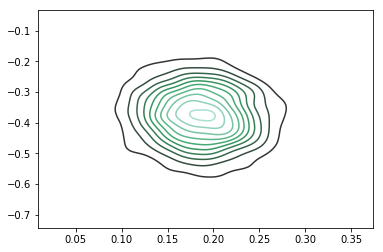

In [53]:
t = 10
sns.kdeplot(samples[:,t,2,0], samples[:,t,0,3])
plt.show()

In [54]:
t = 10
# params[t]

In [55]:
np.mean(samples[:,t], axis=0)

array([[-0.1662, -0.0365, -0.0168, -0.378 ],
       [ 0.105 ,  0.2078,  0.619 ,  0.1935],
       [ 0.1857, -0.0307,  0.8332,  0.8996]])

In [43]:
np.mean(samples[:,t], axis=0)

array([[-0.1967, -0.0331, -0.0692, -0.8973],
       [ 0.0807,  0.1957,  0.629 ,  0.1535],
       [ 0.2592, -0.0342,  0.8069,  1.1076]])

In [278]:
from sklearn.neighbors.kde import KernelDensity
def score(s1, s2):
    bw = 0.1
    s1 = s1[:,np.newaxis]
    s2 = s2[:,np.newaxis]
    e1 = KernelDensity(bandwidth=bw).fit(s1)
    e2 = KernelDensity(bandwidth=bw).fit(s2)
    
    e1e2 = e1.score(s1) - e2.score(s1)
    e2e1 = e2.score(s2) - e1.score(s2)
    dist = (e1e2/len(s1) + e2e1/len(s2))/2
    return dist

In [271]:
def get_cdf(ts):
    return lambda x: (ts <= x).mean()
def score(s1,s2):
    c1 = get_cdf(s1)
    c2 = get_cdf(s2)

    m = 0
    for s in np.concatenate([s1, s2]):
        r = np.abs(c1(s) - c2(s))
        if r > m:
            m = r
    return m

In [203]:
score(s1,s2)

0.00014521624382734903

In [279]:
dists = []
for t1 in range(samples.shape[1] - 1):
    np.random.seed(1234)
    print(t1)
    t2 = t1 + 1
    s1 = samples[:,t1,0,0]
    s2 = samples[:,t2,0,0]
    ss = []
    for _ in range(10):
        s1_ = np.random.choice(s1, size=8000)
        s2_ = np.random.choice(s2, size=8000)
        m = score(s1_,s2_)
        ss.append(m)
    dists.append(ss)
dists = np.array(dists).T

0
1
2
3
4
6
7
8
9
10
11
12
13
14
15
16
17
18


## KDE + KL

/home/nikita/.virtualenvs/py3.6/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


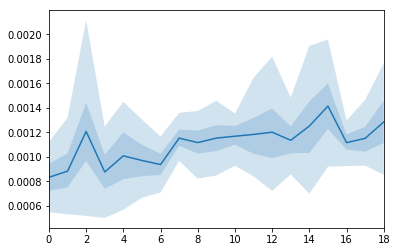

In [270]:
sns.tsplot(dists, ci=[50, 95])
plt.show()

/home/nikita/.virtualenvs/py3.6/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


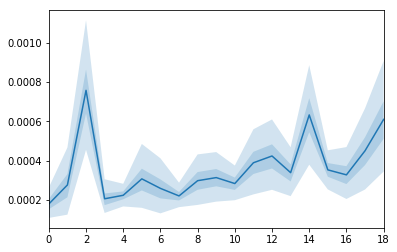

In [280]:
sns.tsplot(dists, ci=[50, 95])
plt.show()

## Kolmogorov-Smirnov

/home/nikita/.virtualenvs/py3.6/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


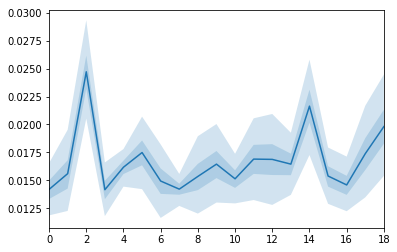

In [277]:
sns.tsplot(dists, ci=[50, 95])
plt.show()

In [ ]:
tf.pow()